In [4]:
import pandas as pd
import os
from datetime import datetime
from datetime import datetime, timedelta
import time as time_lib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from scipy.stats import gaussian_kde
import matplotlib.dates as mdates
from scipy.optimize import linprog
import matplotlib.gridspec as gridspec
from Formulation.P1formulation import P1formulation
from Formulation.P3formulation import P3formulation
import pickle
from sklearn.linear_model import QuantileRegressor
from sklearn.metrics import mean_pinball_loss
import matplotlib.cbook as cbook
import random
from os.path import dirname, join as pjoin
import scipy.io as sio

from sklearn_quantile import (
    RandomForestQuantileRegressor,
    SampleRandomForestQuantileRegressor,
)
import cvxpy as cp

In [9]:
# QR defined function
def qrreg(X,y,quantiles,type,gamma):
    if len(y.shape) == 2:
        y = y.flatten()
    [N,n] = X.shape
    a1 = quantiles[0]
    a2 = quantiles[1]
    SAMPLE_WIDTH = np.quantile(y,a2)-np.quantile(y,a1)
    b = cp.Variable((n,2))
    r1 = cp.Variable(N)
    r2 = cp.Variable(N)
    obj = cp.Minimize(cp.sum( cp.maximum(a1*r1, (a1-1)*r1) + cp.maximum(a2*r2, (a2-1)*r2) ))
    if type == 'qr':
        constraints = [r1 == y-X@b[:,0],
                      r2 == y-X@b[:,1],
                      X@b[:,0] <= X@b[:,1]]
        formulation_solver = cp.ECOS
        
    elif type == 'P1':
        constraints = [r1 == y-X@b[:,0],
                      r2 == y-X@b[:,1],
                      X@b[:,0] <= X@b[:,1],
                      (1/N)*cp.sum(X@b[:,1] - X@b[:,0]) <= gamma*SAMPLE_WIDTH]
        formulation_solver = cp.ECOS

    elif type == 'P2':
        K = np.ceil(0.3*N)
        constraints = [r1 == y-X@b[:,0],
                      r2 == y-X@b[:,1],
                      X@b[:,0] <= X@b[:,1],
                      (1/K)*cp.sum_largest(X@b[:,1] - X@b[:,0],K) <= gamma*SAMPLE_WIDTH]
        formulation_solver = cp.CLARABEL
        
    elif type == 'P3':
        constraints = [r1 == y-X@b[:,0],
                      r2 == y-X@b[:,1],
                      X@b[:,0] <= X@b[:,1],
                      X@b[:,1] - X@b[:,0] <= gamma*SAMPLE_WIDTH]
        formulation_solver = cp.SCIPY
        
    else:
        raise UnknownFormulationError("The available formulation are qr, P1, P2, P3")
        
    formulation = cp.Problem(obj, constraints)
    formulation.solve(solver = formulation_solver)
    
    status = formulation.status
    lowerpred = (X@b[:,0].value).reshape((N,1))
    upperpred = (X@b[:,1].value).reshape((N,1))
    yhat = cp.hstack([lowerpred,upperpred]).value
    bhat = b.value

    return bhat, yhat, status

In [10]:
def evalprobcast(y,yhats):
    yo = y[:,np.newaxis,np.newaxis]
    TMP = (yo >= yhats[:,0,:,:])&(yo <= yhats[:,1,:,:])
    PICP = np.mean(TMP,0)
    width = yhats[:,1,:,:] - yhats[:,0,:,:]
    avgwidth = np.mean(width,0)
    maxwidth = np.max(width,0)
    
    return PICP, avgwidth, maxwidth
    
def PICP(y,upper,lower):
    PICP = sum((y > lower) & (y < upper))/y.shape[0]
    return PICP
    
def widthavgcal(upper,lower):
    widthavg = (upper-lower).mean()
    return widthavg
    
def widthmaxcal(upper,lower):
    widthmax = (upper-lower).max()
    return widthmax

In [11]:
# ax --> figure
# x,y,z ---> lists of x and y (points), z is annotate list
# num_show ---> annotate for index that mod with num_show = 0
def annotate_fig(ax,x,y,z,num_show,color=None, xytext_default=(-5, 5)):
    for i, (X, Y, Z) in enumerate(zip(x, y, z)):
        if i%num_show ==0:
            ax.annotate('{}'.format(round(Z,2)), xy=(X,Y), xytext=xytext_default, ha='right',
                        textcoords='offset points',color=color)
def report_savefig(plotname):
    fig_folder_path = "/Users/worachitjdai/Thesis/conference_code/figures/"
    fig.savefig(fig_folder_path+plotname+".pdf",format='pdf',bbox_inches='tight',pad_inches=0,transparent=True)

In [12]:
resultfolderpath = "/Users/worachitjdai/Thesis/conference_code/results"
datasimfolderpath = "/Users/worachitjdai/Thesis/conference_code/data/simulated_data"

# Data for illustration PI and histogram

## Generate data

In [13]:
## Defined-function of ground truth
def dgplinear(x,b,u):
    return b[0] + x@b[1:] + u

def dgpquad(x,b,u):
    return b[0]+np.concatenate((x,x**2),axis = 1)@b[1:] + u

def dgpnonlin(x,u):
    return 1/(1+2*x**2) + u

def dgptanh(x,u):
    return np.tanh(x**2)+u

def gennoise(noise_sd):
    noise = noise_sd[0]*np.random.normal(0,1,size = (int(np.ceil(N/len(noise_sd))),1))
    for i in range(len(noise_sd)-1):
        if i == len(noise_sd)-2:
            newnoise = noise_sd[i+1]*np.random.normal(0,1,size = (int(N-((len(noise_sd)-1)*np.ceil(N/len(noise_sd)))),1))
        else:
            newnoise = noise_sd[i+1]*np.random.normal(0,1,size = (int(np.ceil(N/len(noise_sd))),1))
        noise = np.concatenate((noise,newnoise))
    return noise

In [14]:
N = 2000 #Number of samples
n = 2 #Define the number of parameters
x = np.random.normal(0,1,(N,n-1))
x = np.sort(x, axis=0)
xtest = np.random.normal(0,1,(N,n-1))
xtest = np.sort(xtest, axis=0)
X = np.block([np.ones((x.shape[0],1)), x])
Xtest = np.block([np.ones((xtest.shape[0],1)), xtest])

# Linear case
btrue = np.random.normal(0,1,size = (n,1)) # ground truth beta
noise_sd = np.sqrt([1,1,5])

In [15]:
# Generate data
u = gennoise(noise_sd)
y = dgplinear(x,btrue,u)
utest = gennoise(noise_sd)
ytest = dgplinear(xtest,btrue,utest)

# np.save(os.path.join(datasimfolderpath,'x_train.npy'), X)
# np.save(os.path.join(datasimfolderpath,'x_test.npy'), Xtest)
# np.save(os.path.join(datasimfolderpath,'y_train.npy'), y)
# np.save(os.path.join(datasimfolderpath,'y_test.npy'), ytest)

In [16]:
# Import generated data
X = np.load(os.path.join(datasimfolderpath,'x_train.npy'))
x = X[:,1].reshape(X.shape[0],1)
Xtest = np.load(os.path.join(datasimfolderpath,'x_test.npy'))
xtest = Xtest[:,1].reshape(Xtest.shape[0],1)
y = np.load(os.path.join(datasimfolderpath,'y_train.npy'))
ytest = np.load(os.path.join(datasimfolderpath,'y_test.npy'))

## Performing QR

In [408]:
conf_interval_list = list(np.round(np.arange(0.1, 0.91, 0.05),2))
RUNS = len(conf_interval_list)
yhats_train_q = np.zeros((N,2,2,RUNS)) # N x (LB,UB) x 2 METHODS (QR,QRF) x NUM_CONF
yhats_test_q = np.zeros((N,2,2,RUNS)) # N x (LB,UB) x 2 METHODS (QR,QRF) x NUM_CONF
bhats_train_qr = np.zeros((n,2,RUNS))
j = 0
for conf_int in conf_interval_list:
    quantiles_vary = [round((1-conf_int)/2,4),round((1+conf_int)/2,4)]
    [bhat, yhat, status] = qrreg(X, y, quantiles_vary, 'qr', 0)
    bhats_train_qr[:,:,j] = bhat
    yhats_train_q[:,:,0,j] = yhat
    yhats_test_q[:,:,0,j] = np.hstack([(Xtest@bhat[:,0]).reshape((N,1)),(Xtest@bhat[:,1]).reshape((N,1))])
    print('Finishing for confidence level '+str(conf_int))
    j = j+1

Finishing for confidence level 0.1
Finishing for confidence level 0.15
Finishing for confidence level 0.2
Finishing for confidence level 0.25
Finishing for confidence level 0.3
Finishing for confidence level 0.35
Finishing for confidence level 0.4
Finishing for confidence level 0.45
Finishing for confidence level 0.5
Finishing for confidence level 0.55
Finishing for confidence level 0.6
Finishing for confidence level 0.65
Finishing for confidence level 0.7
Finishing for confidence level 0.75
Finishing for confidence level 0.8
Finishing for confidence level 0.85
Finishing for confidence level 0.9


## Quantile Regression Forest

### Grid search for hyperparameters

In [430]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer
from pprint import pprint
    
param_grid = dict(
    n_estimators=[50, 100, 150, 200, 250, 300],
    max_depth=[2, 5, 10, 15, 20, 25, 30, 40],
    min_samples_leaf=[1, 4, 8, 10, 20, 30, 40],
    min_samples_split=[2, 5, 10, 20, 30, 50],
    max_features = [None]
)
quantiles = [0.05, 0.95]
for q in quantiles:
    neg_mean_pinball_loss_scorer = make_scorer(
        mean_pinball_loss,
        alpha=q,
        greater_is_better=False,  # maximize the negative loss
    )
    qrf = RandomForestQuantileRegressor(random_state=0, q=q)
    search_p = RandomizedSearchCV(
        qrf,
        param_grid,
        n_iter=10,  # increase this if computational budget allows
        scoring=neg_mean_pinball_loss_scorer,
        n_jobs=2,
        random_state=0,
    ).fit(x,y.ravel())
    print('----- For '+str(q)+' -----')
    pprint(search_p.best_params_)

/Users/worachitjdai/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/worachitjdai/anaconda3/lib/python3.11/site-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/worachitjdai/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/worachitjdai/anaconda3/lib/python3.11/s

----- For 0.05 -----
{'max_depth': 10,
 'max_features': None,
 'min_samples_leaf': 4,
 'min_samples_split': 20,
 'n_estimators': 100}


/Users/worachitjdai/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/worachitjdai/anaconda3/lib/python3.11/site-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/worachitjdai/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/worachitjdai/anaconda3/lib/python3.11/s

----- For 0.95 -----
{'max_depth': 20,
 'max_features': None,
 'min_samples_leaf': 30,
 'min_samples_split': 30,
 'n_estimators': 250}


### Performing QRF

In [449]:
conf_interval_list = list(np.round(np.arange(0.1, 0.91, 0.05),2))
j = 0
for conf_int in conf_interval_list:
    print('-----For nominal confidence level : '+str(conf_int)+'-----')
    quantiles_vary = [round((1-conf_int)/2,4),round((1+conf_int)/2,4)]
    for k in range(len(quantiles_vary)):
        if k == 0: #For lower bound
            common_params = dict(max_depth=10,
                                    max_features = None,
                                    min_samples_leaf=4,
                                    min_samples_split=20,
                                    n_estimators=100)
        elif k == 1: #For upper bound
            common_params = dict(max_depth=20,
                                    max_features = None,
                                    min_samples_leaf=30,
                                    min_samples_split=30,
                                    n_estimators=250)
        qrf = RandomForestQuantileRegressor(**common_params, q=quantiles_vary[k])
        qrf.fit(x, y.ravel())
        yhats_train_q[:,k,1,j] = qrf.predict(x) 
        # For test data
        yhats_test_q[:,k,1,j] = qrf.predict(xtest)
    j = j+1

-----For nominal confidence level : 0.1-----


/Users/worachitjdai/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/worachitjdai/anaconda3/lib/python3.11/site-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/worachitjdai/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/worachitjdai/anaconda3/lib/python3.11/s

-----For nominal confidence level : 0.15-----


/Users/worachitjdai/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/worachitjdai/anaconda3/lib/python3.11/site-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/worachitjdai/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/worachitjdai/anaconda3/lib/python3.11/s

-----For nominal confidence level : 0.2-----


/Users/worachitjdai/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/worachitjdai/anaconda3/lib/python3.11/site-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/worachitjdai/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/worachitjdai/anaconda3/lib/python3.11/s

-----For nominal confidence level : 0.25-----


/Users/worachitjdai/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/worachitjdai/anaconda3/lib/python3.11/site-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/worachitjdai/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/worachitjdai/anaconda3/lib/python3.11/s

-----For nominal confidence level : 0.3-----


/Users/worachitjdai/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/worachitjdai/anaconda3/lib/python3.11/site-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/worachitjdai/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/worachitjdai/anaconda3/lib/python3.11/s

-----For nominal confidence level : 0.35-----


/Users/worachitjdai/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/worachitjdai/anaconda3/lib/python3.11/site-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/worachitjdai/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/worachitjdai/anaconda3/lib/python3.11/s

-----For nominal confidence level : 0.4-----


/Users/worachitjdai/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/worachitjdai/anaconda3/lib/python3.11/site-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/worachitjdai/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/worachitjdai/anaconda3/lib/python3.11/s

-----For nominal confidence level : 0.45-----


/Users/worachitjdai/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/worachitjdai/anaconda3/lib/python3.11/site-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/worachitjdai/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/worachitjdai/anaconda3/lib/python3.11/s

-----For nominal confidence level : 0.5-----


/Users/worachitjdai/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/worachitjdai/anaconda3/lib/python3.11/site-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/worachitjdai/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/worachitjdai/anaconda3/lib/python3.11/s

-----For nominal confidence level : 0.55-----


/Users/worachitjdai/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/worachitjdai/anaconda3/lib/python3.11/site-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/worachitjdai/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/worachitjdai/anaconda3/lib/python3.11/s

-----For nominal confidence level : 0.6-----


/Users/worachitjdai/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/worachitjdai/anaconda3/lib/python3.11/site-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/worachitjdai/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/worachitjdai/anaconda3/lib/python3.11/s

-----For nominal confidence level : 0.65-----


/Users/worachitjdai/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/worachitjdai/anaconda3/lib/python3.11/site-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/worachitjdai/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/worachitjdai/anaconda3/lib/python3.11/s

-----For nominal confidence level : 0.7-----


/Users/worachitjdai/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/worachitjdai/anaconda3/lib/python3.11/site-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/worachitjdai/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/worachitjdai/anaconda3/lib/python3.11/s

-----For nominal confidence level : 0.75-----


/Users/worachitjdai/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/worachitjdai/anaconda3/lib/python3.11/site-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/worachitjdai/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/worachitjdai/anaconda3/lib/python3.11/s

-----For nominal confidence level : 0.8-----


/Users/worachitjdai/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/worachitjdai/anaconda3/lib/python3.11/site-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/worachitjdai/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/worachitjdai/anaconda3/lib/python3.11/s

-----For nominal confidence level : 0.85-----


/Users/worachitjdai/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/worachitjdai/anaconda3/lib/python3.11/site-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/worachitjdai/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/worachitjdai/anaconda3/lib/python3.11/s

-----For nominal confidence level : 0.9-----


/Users/worachitjdai/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/worachitjdai/anaconda3/lib/python3.11/site-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/worachitjdai/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/worachitjdai/anaconda3/lib/python3.11/s

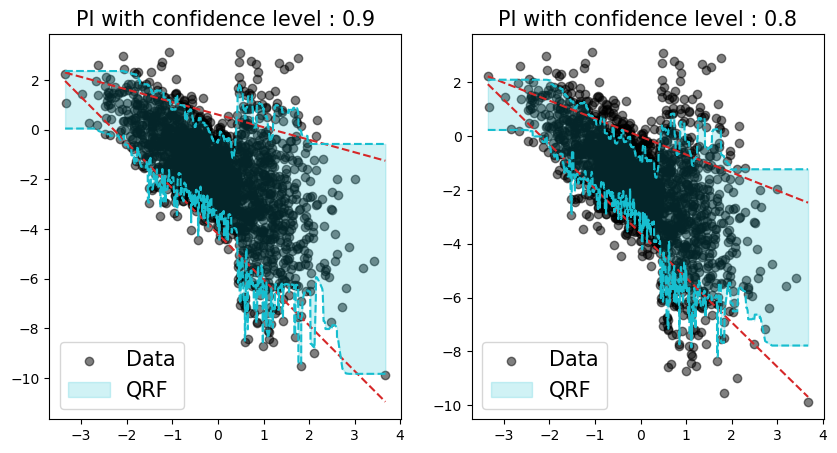

In [18]:
conf_interval_list = list(np.round(np.arange(0.1, 0.91, 0.05),2))
fig,ax = plt.subplots(nrows=1,ncols=2)
conf_list_plot = [0.9,0.8]
fig.set_size_inches(10,5)
i = 0

for conf_int in conf_list_plot:
    conf_index = conf_interval_list.index(conf_int)
    ax[i].scatter(x.flatten(),y,label='Data',color='black',alpha=0.5)
    for k in range(2): ## Upper-lower bound
        ax[i].plot(x.flatten(),yhats_train_q[:,k,0,conf_index],color='tab:red',linestyle='dashed')
        ax[i].plot(x.flatten(),yhats_train_q[:,k,1,conf_index],color='tab:cyan',linestyle='dashed')
    ax[i].fill_between(x.flatten(),yhats_train_q[:,0,1,conf_index],yhats_train_q[:,1,1,conf_index],alpha=0.2,color='tab:cyan',label='QRF')
    ax[i].set_title('PI with confidence level : '+str(conf_int),fontsize=15)
    # ax[i].set_xlim(-1,0)
    ax[i].legend(fontsize=15)
    i = i+1

In [453]:
# Save QR, QRF result
np.save(os.path.join(resultfolderpath,'x_train.npy'), X)
np.save(os.path.join(resultfolderpath,'x_test.npy'), Xtest)
np.save(os.path.join(resultfolderpath,'yhats_train_qrqrf.npy'), yhats_train_q)
np.save(os.path.join(resultfolderpath,'yhats_test_qrqrf.npy'), yhats_test_q)

## Performing P1, P2, and P3

In [395]:
[N,n] = X.shape
RUNS = len(gammavec)
bhats_train = np.zeros((n,2,3,RUNS)) # n x (LB,UB) x 3 METHODS x NUM_GAMMA
yhats_train = np.zeros((N,2,3,RUNS)) # N x (LB,UB) x 3 METHODS x NUM_GAMMA
yhats_test = np.zeros((N,2,3,RUNS)) # N x (LB,UB) x 3 METHODS x NUM_GAMMA

optstatus_train = np.empty(shape=(3,RUNS), dtype=object) # 3 METHODS x NUM_GAMMA
method = ['P1', 'P2', 'P3']

j = 0
for gamma in gammavec:
    for k in range(len(method)):
        [bhat, yhat, status] = qrreg(X, y, quantiles, method[k], gamma)
        bhats_train[:,:,k,j] = bhat
        yhats_train[:,:,k,j] = yhat
        yhats_test[:,:,k,j] = np.hstack([(Xtest@bhat[:,0]).reshape((N,1)),(Xtest@bhat[:,1]).reshape((N,1))])
        optstatus_train[k,j] = status
        print('Finishing '+method[k]+' for gamma '+str(gamma))
    j = j+1

Finishing P1 for gamma 0.5
Finishing P2 for gamma 0.5
Finishing P3 for gamma 0.5
Finishing P1 for gamma 0.55
Finishing P2 for gamma 0.55
Finishing P3 for gamma 0.55
Finishing P1 for gamma 0.6
Finishing P2 for gamma 0.6
Finishing P3 for gamma 0.6
Finishing P1 for gamma 0.65
Finishing P2 for gamma 0.65
Finishing P3 for gamma 0.65
Finishing P1 for gamma 0.7
Finishing P2 for gamma 0.7
Finishing P3 for gamma 0.7
Finishing P1 for gamma 0.75
Finishing P2 for gamma 0.75
Finishing P3 for gamma 0.75
Finishing P1 for gamma 0.8
Finishing P2 for gamma 0.8
Finishing P3 for gamma 0.8
Finishing P1 for gamma 0.85
Finishing P2 for gamma 0.85
Finishing P3 for gamma 0.85
Finishing P1 for gamma 0.9
Finishing P2 for gamma 0.9
Finishing P3 for gamma 0.9
Finishing P1 for gamma 0.95
Finishing P2 for gamma 0.95
Finishing P3 for gamma 0.95
Finishing P1 for gamma 1.0
Finishing P2 for gamma 1.0
Finishing P3 for gamma 1.0


In [452]:
# Save P1, P2, and P3 result
np.save(os.path.join(resultfolderpath,'yhats_train_formulation.npy'), yhats_train)
np.save(os.path.join(resultfolderpath,'yhats_test_formulation.npy'), yhats_test)

## Data for illustration PI

In [17]:
X = np.load(os.path.join(datasimfolderpath,'x_train.npy'))
Xtest = np.load(os.path.join(datasimfolderpath,'x_test.npy'))
y = np.load(os.path.join(datasimfolderpath,'y_train.npy'))
ytest = np.load(os.path.join(datasimfolderpath,'y_test.npy'))

yhats_train_q = np.load(os.path.join(resultfolderpath,'yhats_train_qrqrf.npy'))
yhats_test_q = np.load(os.path.join(resultfolderpath,'yhats_test_qrqrf.npy'))
yhats_train = np.load(os.path.join(resultfolderpath,'yhats_train_formulation.npy'))
yhats_test = np.load(os.path.join(resultfolderpath,'yhats_test_formulation.npy'))

## PI plot

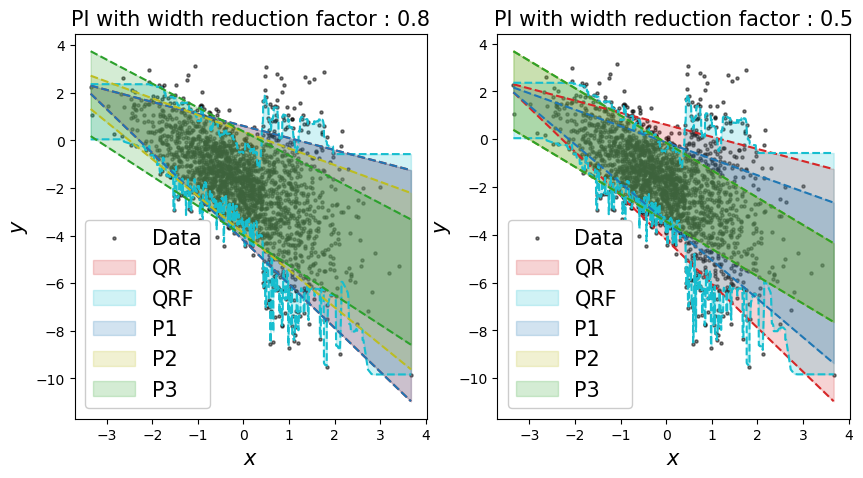

In [19]:
fig,ax = plt.subplots(nrows=1,ncols=2)
gammavec = list(np.round(np.arange(0.5, 1.01, 0.05),2))
conf_interval_list = list(np.round(np.arange(0.1, 0.91, 0.05),2))
gamma_list = [0.8,0.5]
quantiles = [0.05,0.95]
fig.set_size_inches(10,5)
i = 0
color_list = ['tab:red','tab:cyan','tab:blue','tab:olive','tab:green']
for gamma in gamma_list:
    gamma_index = gammavec.index(gamma)
    xplot = x.flatten()
    ax[i].scatter(xplot,y,label='Data',color='black',alpha=0.5,s=5)
    for k in range(2): ## Upper-lower bound
        ax[i].plot(xplot,yhats_train_q[:,k,0,-1],color=color_list[0],linestyle='dashed') #plot for 0.9 confidence
        ax[i].plot(xplot,yhats_train_q[:,k,1,-1],color=color_list[1],linestyle='dashed') #plot for 0.9 confidence
        ax[i].plot(xplot,yhats_train[:,k,0,gamma_index],color=color_list[2],linestyle='dashed')
        ax[i].plot(xplot,yhats_train[:,k,1,gamma_index],color=color_list[3],linestyle='dashed')
        ax[i].plot(xplot,yhats_train[:,k,2,gamma_index],color=color_list[4],linestyle='dashed')
    ax[i].fill_between(xplot,yhats_train_q[:,0,0,-1],yhats_train_q[:,1,0,-1],alpha=0.2,color=color_list[0],label='QR')
    ax[i].fill_between(xplot,yhats_train_q[:,0,1,-1],yhats_train_q[:,1,1,-1],alpha=0.2,color=color_list[1],label='QRF')
    ax[i].fill_between(xplot,yhats_train[:,0,0,gamma_index],yhats_train[:,1,0,gamma_index],alpha=0.2,color=color_list[2],label='P1')
    ax[i].fill_between(xplot,yhats_train[:,0,1,gamma_index],yhats_train[:,1,1,gamma_index],alpha=0.2,color=color_list[3],label='P2')
    ax[i].fill_between(xplot,yhats_train[:,0,2,gamma_index],yhats_train[:,1,2,gamma_index],alpha=0.2,color=color_list[4],label='P3')
    ax[i].set_title('PI with width reduction factor : '+str(gamma),fontsize=15)
    ax[i].legend(fontsize=15,framealpha=1)
    ax[i].set_xlabel("$x$",fontsize=15)
    ax[i].set_ylabel("$y$",fontsize=15)
    i = i+1

## Histogram

In [20]:
# Calculate PICP
PICP_QR = []
PICP_QRF = []
PICP_P1 = []
PICP_P2 = []
PICP_P3 = []

for conf_int in conf_interval_list:
    conf_index = conf_interval_list.index(conf_int)
    PICP_QR.append(PICP(y.flatten(),yhats_train_q[:,1,0,conf_index],yhats_train_q[:,0,0,conf_index]))
    PICP_QRF.append(PICP(y.flatten(),yhats_train_q[:,1,1,conf_index],yhats_train_q[:,0,1,conf_index]))

for gamma in gammavec:
    gamma_index = gammavec.index(gamma)
    PICP_P1.append(PICP(y.flatten(),yhats_train[:,1,0,gamma_index],yhats_train[:,0,0,gamma_index]))
    PICP_P2.append(PICP(y.flatten(),yhats_train[:,1,1,gamma_index],yhats_train[:,0,1,gamma_index]))
    PICP_P3.append(PICP(y.flatten(),yhats_train[:,1,2,gamma_index],yhats_train[:,0,2,gamma_index]))

PICP of P1 given penalty_show 0.9
PICP of P2 given penalty_show 0.889
PICP of P3 given penalty_show 0.877
closest PICP of QR given penalty_show 0.9
PICP of P1 given penalty_show 0.884
PICP of P2 given penalty_show 0.8405
PICP of P3 given penalty_show 0.8695
closest PICP of QR given penalty_show 0.9


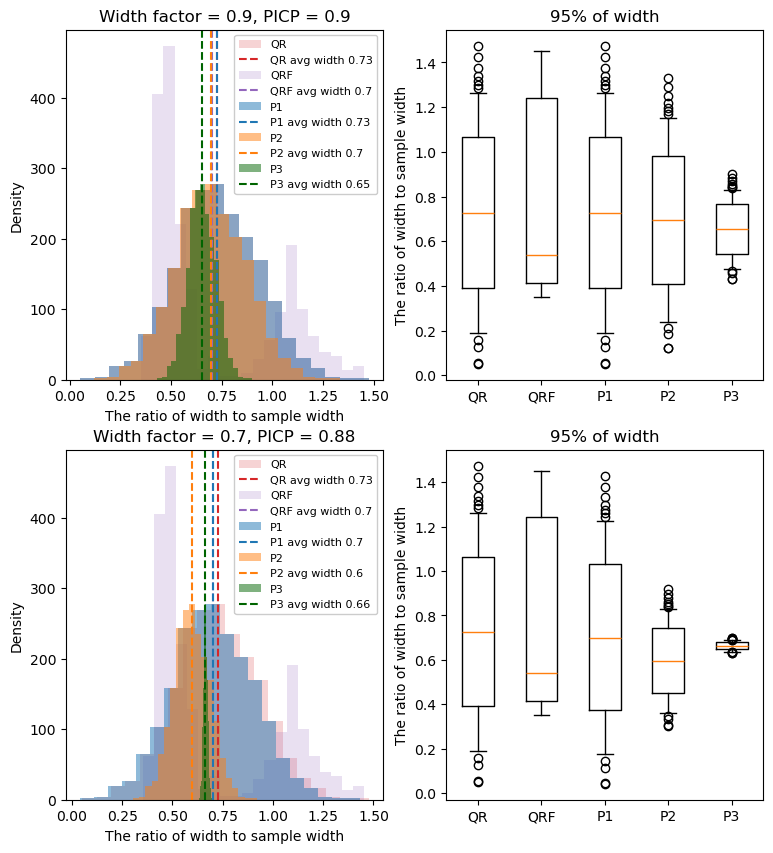

In [21]:
gamma_list = [0.9,0.75]
gamma_list = [0.9,0.7]
fig,ax = plt.subplots(nrows=2,ncols=2)
fig.set_size_inches(9, 10)
i = 0
sample_width = abs(np.quantile(y,quantiles[1])-np.quantile(y,quantiles[0]))
color_list = ['tab:red','tab:purple','tab:blue','tab:orange','darkgreen']
label_hist_plot = ['QR', 'QRF', 'P1', 'P2', 'P3']
alpha_plot = [0.2, 0.2, 0.5, 0.5, 0.5]

for gamma in gamma_list:
    #FIND CONFIDENCE INTERVAL CLOSEST TO PICP FROM P1 GIVEN PENALTY_SHOW
    gamma_index = gammavec.index(gamma)
    PICP_P1_given_penalty = PICP_P1[gamma_index]
    PICP_P2_given_penalty = PICP_P2[gamma_index]
    PICP_P3_given_penalty = PICP_P3[gamma_index]
    
    print('PICP of P1 given penalty_show '+str(PICP_P1_given_penalty))
    print('PICP of P2 given penalty_show '+str(PICP_P2_given_penalty))
    print('PICP of P3 given penalty_show '+str(PICP_P3_given_penalty))
    
    sorted_list = sorted(PICP_QR, key=lambda x: abs(PICP_P1_given_penalty - x))
    sorted_list_2 = sorted(conf_interval_list, key=lambda x: abs(sorted_list[0] - x))
    #Find the closest PICP of QR to P1 with given gamma
    conf_show = sorted_list_2[0] 
    print('closest PICP of QR given penalty_show '+str(conf_show))
    conf_index = conf_interval_list.index(conf_show)
      
    width_QR = (yhats_train_q[:,1,0,conf_index]-yhats_train_q[:,0,0,conf_index])/sample_width
    width_QRF = (yhats_train_q[:,1,1,conf_index]-yhats_train_q[:,0,1,conf_index])/sample_width
    width_P1 = (yhats_train[:,1,0,gamma_index]-yhats_train[:,0,0,gamma_index])/sample_width
    width_P2 = (yhats_train[:,1,1,gamma_index]-yhats_train[:,0,1,gamma_index])/sample_width
    width_P3 = (yhats_train[:,1,2,gamma_index]-yhats_train[:,0,2,gamma_index])/sample_width
    width_plot = [width_QR, width_QRF, width_P1, width_P2, width_P3]

    stats = {}
    for j in range(len(width_plot)):
        ax[i,0].hist(width_plot[j],bins=20,alpha = alpha_plot[j], density=False,color = color_list[j],label=label_hist_plot[j])
        ax[i,0].axvline(np.mean(width_plot[j]),color = color_list[j], linestyle='dashed', linewidth=1.5, label = label_hist_plot[j]+' avg width '+str(round(np.mean(width_plot[j]),2)))
        # Compute the boxplot stats (as in the default matplotlib implementation)
        stats[label_hist_plot[j]] = cbook.boxplot_stats(width_plot[j])[0]
        # For all boxes compute the 5th and 95th percentiles
        stats[label_hist_plot[j]]['q1'], stats[label_hist_plot[j]]['q3'] = np.percentile(width_plot[j], [5, 95])
    
    ax[i,0].set_title("Width factor = "+str(gamma)+", PICP = "+str(round(PICP_P1_given_penalty,2)))
    ax[i,0].legend(fontsize=8,framealpha=1)
    ax[i,0].set_xlabel("The ratio of width to sample width")
    ax[i,0].set_ylabel("Density")
    
    bp = ax[i,1].bxp([stats['QR'], stats['QRF'], stats['P1'], stats['P2'], stats['P3']],meanline = True)
    ax[i,1].set_xticklabels(label_hist_plot)
    ax[i,1].set_ylabel('The ratio of width to sample width')
    ax[i,1].set_title('95% of width')
    i = i +1
# report_savefig("toy_histogram_width_qrqrfp1p2p3")


# Result of 100 trials of data

In [22]:
quantiles = [0.05, 0.95]
gammavec = list(np.round(np.arange(0.5, 1.01, 0.05),2))
conf_interval_list = list(np.round(np.arange(0.1, 0.91, 0.05),2))

## Generate data

In [23]:
# Generate data for 100 samples ******
SAMPLES = 100
N = 2000
btrue = np.random.normal(0,1,size = (n,1)) # ground truth beta
noise_sd = np.sqrt([1,1,5])

data_100_x = np.random.normal(0,1,(N,n-1))
data_100_x = np.sort(data_100_x, axis=0)
data_100_ally = np.zeros((N,SAMPLES))
for i in range(SAMPLES):
    u = gennoise(noise_sd)
    data_100_ally[:,i] = dgplinear(data_100_x,btrue,u).flatten()

# np.save(os.path.join(datasimfolderpath,'data_100_y.npy'), data_100['all_y'])
# np.save(os.path.join(datasimfolderpath,'data_100_x.npy'), data_100['x'])

In [24]:
# Import generated data
data_100_ally = np.load(os.path.join(datasimfolderpath,'data_100_y.npy'))
data_100_x = np.load(os.path.join(datasimfolderpath,'data_100_x.npy'))

## Performing QR

In [34]:
yhatsqr = np.zeros((data_100_ally.shape[0],2,len(conf_interval_list),data_100_ally.shape[1])) # n x (LB,UB) x NUM_CONF x SAMPLES
## Solve many confidence level for QR
conf_interval_list = list(np.round(np.arange(0.1, 0.91, 0.05),2))
for i in range(data_100_ally.shape[1]): #Iterate over SAMPLES
    print('SAMPLE : '+str(i))
    j = 0
    for conf_int in conf_interval_list: #Iterate over conf_interval
        # print('-----For nominal confidence level : '+str(conf_int)+'-----')
        quantiles_vary = [round((1-conf_int)/2,4),round((1+conf_int)/2,4)]
        k = 0
        for quantile in quantiles_vary: #Iterate LB and UB
            qr = QuantileRegressor(quantile=quantile,alpha = 0, fit_intercept=True,solver='highs')
            model = qr.fit(data_100_x, data_100_ally[:,i])
            yhatsqr[:,k,j,i] = model.predict(data_100_x)
            k = k + 1
        j = j + 1
# np.save(os.path.join(resultfolderpath,'yhatsqr.npy'), yhatsqr)

SAMPLE : 0
SAMPLE : 1
SAMPLE : 2


KeyboardInterrupt: 

## Import QR result

In [25]:
yhatsqr = np.load(os.path.join(resultfolderpath,'yhatsqr.npy'))

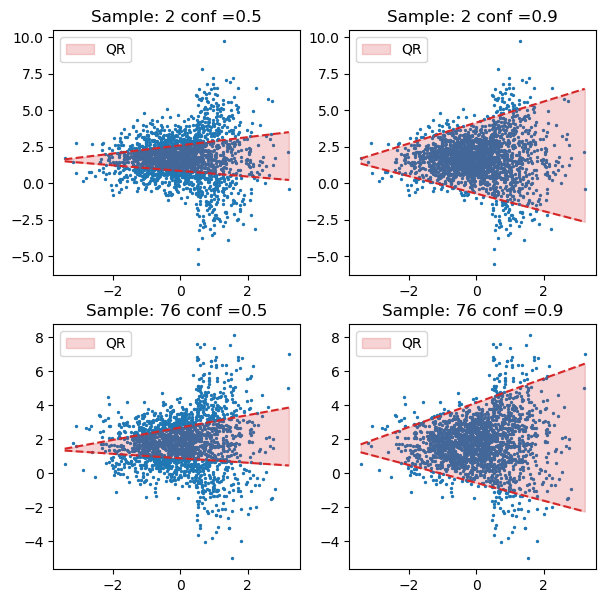

In [26]:
datasamplelist = [2,76]
confplotlist = [0.5,0.9]
fig,ax = plt.subplots(nrows=len(datasamplelist),ncols=len(confplotlist))
fig.set_size_inches(7,7)
i = 0
for datasample in datasamplelist:
    yplot = data_100_ally[:,datasample]
    xplot = data_100_x
    j = 0
    for confplot in confplotlist:
        ax[i,j].scatter(xplot, yplot, s=2)
        u = yhatsqr[:,1,conf_interval_list.index(confplot), datasample]
        l = yhatsqr[:,0,conf_interval_list.index(confplot), datasample]
        ax[i,j].plot(xplot, l, color='tab:red', linestyle='dashed')
        ax[i,j].plot(xplot, u, color='tab:red', linestyle='dashed')
        ax[i,j].fill_between(xplot.flatten(),l,u,alpha=0.2,color='tab:red',label='QR')
        ax[i,j].set_title('Sample: '+str(datasample)+' conf ='+str(confplot))
        ax[i,j].legend()
        j = j+1
    i = i+1

## Performing QRF

In [38]:
yhatsqrf = np.zeros((data_100_ally.shape[0],2,len(conf_interval_list),data_100_ally.shape[1])) # n x (LB,UB) x NUM_CONF x SAMPLES
## Solve many confidence level for QRF
conf_interval_list = list(np.round(np.arange(0.1, 0.91, 0.05),2))
for i in range(data_100_ally.shape[1]): #Iterate over SAMPLES
    print('SAMPLE : '+str(i))
    j = 0
    for conf_int in conf_interval_list: #Iterate over conf_interval
        # print('-----For nominal confidence level : '+str(conf_int)+'-----')
        quantiles_vary = [round((1-conf_int)/2,4),round((1+conf_int)/2,4)]
        k = 0
        for quantile in quantiles_vary: #Iterate LB and UB
            if quantile == quantiles_vary[0]: #For lower bound
                common_params = dict(max_depth=10,
                                        max_features = None,
                                        min_samples_leaf=4,
                                        min_samples_split=20,
                                        n_estimators=100)
            else: #For upper bound
                common_params = dict(max_depth=20,
                                        max_features = None,
                                        min_samples_leaf=30,
                                        min_samples_split=30,
                                        n_estimators=250)
            qrf = RandomForestQuantileRegressor(**common_params, q=quantile)
            qrf.fit(data_100_x, data_100_ally[:,i])
            yhatsqrf[:,k,j,i] = qrf.predict(data_100_x)
            k = k + 1
        j = j + 1
# np.save(os.path.join(resultfolderpath,'yhatsqrf.npy'), yhatsqrf)

SAMPLE : 0


/Users/worachitjdai/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/worachitjdai/anaconda3/lib/python3.11/site-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/worachitjdai/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/worachitjdai/anaconda3/lib/python3.11/s

SAMPLE : 1


/Users/worachitjdai/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/worachitjdai/anaconda3/lib/python3.11/site-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/worachitjdai/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/worachitjdai/anaconda3/lib/python3.11/s

KeyboardInterrupt: 

## Import QRF result

In [27]:
# Import data
yhatsqrf = np.load(os.path.join(resultfolderpath,'yhatsqrf.npy'))

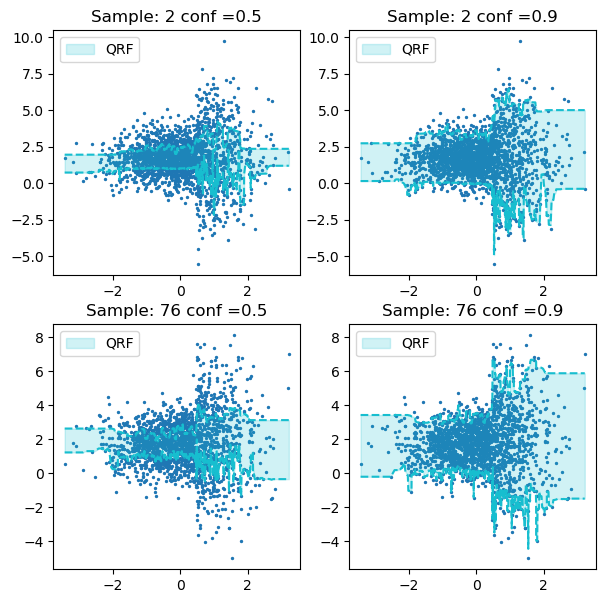

In [28]:
datasamplelist = [2,76]
confplotlist = [0.5,0.9]
fig,ax = plt.subplots(nrows=len(datasamplelist),ncols=len(confplotlist))
fig.set_size_inches(7,7)
i = 0
for datasample in datasamplelist:
    yplot = data_100_ally[:,datasample]
    xplot = data_100_x
    j = 0
    for confplot in confplotlist:
        ax[i,j].scatter(xplot, yplot, s=2)
        u = yhatsqrf[:,1,conf_interval_list.index(confplot), datasample]
        l = yhatsqrf[:,0,conf_interval_list.index(confplot), datasample]
        ax[i,j].plot(xplot, l, color='tab:cyan', linestyle='dashed')
        ax[i,j].plot(xplot, u, color='tab:cyan', linestyle='dashed')
        ax[i,j].fill_between(xplot.flatten(),l,u,alpha=0.2,color='tab:cyan',label='QRF')
        ax[i,j].set_title('Sample: '+str(datasample)+' conf ='+str(confplot))
        ax[i,j].legend()
        j = j+1
    i = i+1

## For P1, P2, P3

In [29]:
quantiles = [0.05, 0.95]
gammavec = list(np.round(np.arange(0.5, 1.01, 0.05),2))
conf_interval_list = list(np.round(np.arange(0.1, 0.91, 0.05),2))

In [30]:
x = data_100_x
X = np.block([np.ones((x.shape[0],1)), x])
[N,n] = X.shape

### Performming P1, P2, P3

In [44]:
SAMPLES = data_100_ally.shape[1]
RUNS = len(gammavec)
bhats = np.zeros((n,2,3,RUNS)) # n x (LB,UB) x 3 METHODS x NUM_GAMMA
allbhats = np.zeros((n,2,3,RUNS,SAMPLES)) # n x (LB,UB) x 3 METHODS x NUM_GAMMA
yhats = np.zeros((N,2,3,RUNS)) # N x (LB,UB) x 3 METHODS x NUM_GAMMA
allyhats = np.zeros((N,2,3,RUNS,SAMPLES)) # N x (LB,UB) x 3 METHODS x NUM_GAMMA x SAMPLES
allstatus = np.empty(shape=(3,RUNS,SAMPLES), dtype=object) # 3 METHODS x NUM_GAMMA x SAMPLES
method = ['P1', 'P2', 'P3']
for i in range(SAMPLES):
    print('For sample: '+str(i+1))
    j = 0
    for gamma in gammavec:
        for k in range(len(method)):
            [bhat, yhat, status] = qrreg(X, data_100_ally[:,i], quantiles, method[k], gamma)
            bhats[:,:,k,j] = bhat
            yhats[:,:,k,j] = yhat
            allstatus[k,j,i] = status
            print('Finishing '+method[k]+' for gamma '+str(gamma))
        j = j+1
    allyhats[:,:,:,:,i] = yhats
    allbhats[:,:,:,:,i] = bhats
    
    # np.save(os.path.join(resultfolderpath,'allyhats.npy'), allyhats)
    # np.save(os.path.join(resultfolderpath,'allbhats.npy'), allbhats
    # np.save(os.path.join(resultfolderpath,'allstatus.npy'), allstatus)

For sample: 1
Finishing P1 for gamma 0.5
Finishing P2 for gamma 0.5
Finishing P3 for gamma 0.5
Finishing P1 for gamma 0.55
Finishing P2 for gamma 0.55
Finishing P3 for gamma 0.55
Finishing P1 for gamma 0.6
Finishing P2 for gamma 0.6
Finishing P3 for gamma 0.6
Finishing P1 for gamma 0.65
Finishing P2 for gamma 0.65
Finishing P3 for gamma 0.65
Finishing P1 for gamma 0.7
Finishing P2 for gamma 0.7
Finishing P3 for gamma 0.7
Finishing P1 for gamma 0.75
Finishing P2 for gamma 0.75
Finishing P3 for gamma 0.75
Finishing P1 for gamma 0.8
Finishing P2 for gamma 0.8
Finishing P3 for gamma 0.8
Finishing P1 for gamma 0.85
Finishing P2 for gamma 0.85
Finishing P3 for gamma 0.85
Finishing P1 for gamma 0.9
Finishing P2 for gamma 0.9
Finishing P3 for gamma 0.9
Finishing P1 for gamma 0.95
Finishing P2 for gamma 0.95
Finishing P3 for gamma 0.95
Finishing P1 for gamma 1.0
Finishing P2 for gamma 1.0
Finishing P3 for gamma 1.0
For sample: 2
Finishing P1 for gamma 0.5
Finishing P2 for gamma 0.5
Finishing P3

KeyboardInterrupt: 

### Import P1, P2, P3 result

In [31]:
allyhats = np.load(os.path.join(resultfolderpath,'allyhats.npy'))
allbhats = np.load(os.path.join(resultfolderpath,'allbhats.npy'))
allstatus = np.load(os.path.join(resultfolderpath,'allstatus.npy'),allow_pickle=True)

In [32]:
## Check fail in optimization status
total = np.zeros((allstatus.shape[0],allstatus.shape[1]))
numfail = np.zeros((allstatus.shape[0],allstatus.shape[1]))
for i in range(allstatus.shape[0]):
    for j in range(allstatus.shape[1]):
        total[i,j] = 0
        numfail[i,j] = 0
        for k in range(allstatus.shape[2]):
            total[i,j] = total[i,j] + 1
            if allstatus[i,j,k] != 'optimal':
                numfail[i,j] = numfail[i,j] + 1
print("The number of failed cases is "+str(np.sum(numfail)))

The number of failed cases is 0.0


## Calculating width and PICP averaging all trials

In [33]:
allpicp_Q = np.zeros((2,len(conf_interval_list),data_100_ally.shape[1])) # 2(QR,QRF) x NUM_CONF x SAMPLES
allavgwidth_Q = np.zeros((2,len(conf_interval_list),data_100_ally.shape[1])) # 2(QR,QRF) x NUM_CONF x SAMPLES
allmaxwidth_Q = np.zeros((2,len(conf_interval_list),data_100_ally.shape[1])) # 2(QR,QRF) x NUM_CONF x SAMPLES

## Calculating PICP, width for QR, QRF (width are divided with sample_width)
quantiles = [0.05,0.95]
qr_method_forecasts = [yhatsqr,yhatsqrf]
for i in range(data_100_ally.shape[1]): #Iterate over SAMPLES
    sample_width = np.quantile(data_100_ally[:,i],quantiles[1])-np.quantile(data_100_ally[:,i],quantiles[0])
    j = 0
    for conf_int in conf_interval_list: #Iterate over conf_interval
        k = 0
        for yhat in qr_method_forecasts:
            lower = yhat[:,0,j,i]
            upper = yhat[:,1,j,i]
            allpicp_Q[k,j,i] = PICP(data_100_ally[:,i],upper,lower)
            allavgwidth_Q[k,j,i] = widthavgcal(upper,lower)/sample_width
            allmaxwidth_Q[k,j,i] = widthmaxcal(upper,lower)/sample_width
            k = k+1
        j = j + 1

# Averaging all samples

## QR
width_dict_QR_avgallsamples = {"avg":[],"max":[]}
width_dict_QR_avgallsamples["avg"] = np.mean(allavgwidth_Q,axis=2)[0]
width_dict_QR_avgallsamples["max"] = np.mean(allmaxwidth_Q,axis=2)[0]
PICP_QR_avg = np.mean(allpicp_Q,axis=2)[0]
## QRF 
width_dict_QRF_avgallsamples = {"avg":[],"max":[]}
width_dict_QRF_avgallsamples["avg"] = np.mean(allavgwidth_Q,axis=2)[1]
width_dict_QRF_avgallsamples["max"] = np.mean(allmaxwidth_Q,axis=2)[1]
PICP_QRF_avg =np.mean(allpicp_Q,axis=2)[1]

In [34]:
# P1, P2, P3
allPICP_P = np.zeros((3,len(gammavec),data_100_ally.shape[1])) # 3(P1,P2,P3) x NUM_GAMMA x SAMPLES
allavgwidth_P = np.zeros((3,len(gammavec),data_100_ally.shape[1]))
allmaxwidth_P = np.zeros((3,len(gammavec),data_100_ally.shape[1]))
for i in range(data_100_ally.shape[1]):  
    sample_width = np.quantile(data_100_ally[:,i],quantiles[1])-np.quantile(data_100_ally[:,i],quantiles[0])
    yhats = allyhats[:,:,:,:,i]
    [PICP, avgwidth, maxwidth] = evalprobcast(data_100_ally[:,i],yhats)
    allPICP_P[:,:,i] = PICP
    allavgwidth_P[:,:,i] = avgwidth/sample_width
    allmaxwidth_P[:,:,i] = maxwidth/sample_width

avgPICP = np.mean(allPICP_P,2)
avgavgwidth = np.mean(allavgwidth_P,2)
avgmaxwidth = np.mean(allmaxwidth_P,2)

(0.4, 2.15)

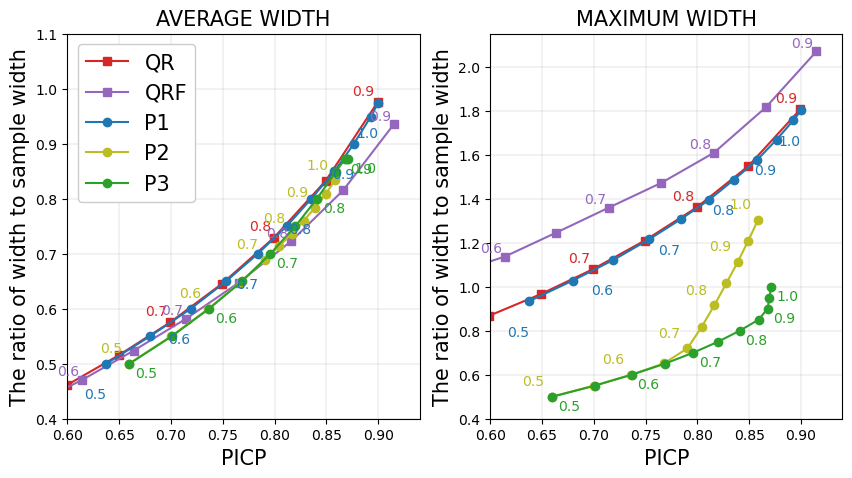

In [35]:
# For 100 realizations
## PICP and width tradeoff
nrows = 1
ncols = 2
fig,ax = plt.subplots(nrows=nrows,ncols=ncols)
fig.set_size_inches(10, 5)

widthtypelist = ['avg','max']
formulation_color = ['tab:red','tab:purple','tab:blue','tab:olive','tab:green']
formulation_label = ['QR','QRF','P1','P2','P3']
row = 0
i = 0
for widthtype in widthtypelist:
    # For QR
    x_QR = PICP_QR_avg
    y_2_QR = width_dict_QR_avgallsamples[widthtype]
    z_QR = conf_interval_list
    ax[row].plot(x_QR,y_2_QR,marker='s',color=formulation_color[0],label=formulation_label[0])
    annotate_fig(ax[row],x_QR,y_2_QR,z_QR,2,color=formulation_color[0], xytext_default=(-2, 5))

    # For QRF
    x_QRF = PICP_QRF_avg
    y_2_QRF = width_dict_QRF_avgallsamples[widthtype]
    z_QRF = conf_interval_list
    ax[row].plot(x_QRF,y_2_QRF,marker='s',color=formulation_color[1],label=formulation_label[1])
    annotate_fig(ax[row],x_QRF,y_2_QRF,z_QRF,2,color=formulation_color[1], xytext_default=(-2, 3))

    #For P1, P2, P3
    formulation_textpos = [(0,-25),(-5,8),(20,-10)]
    for j in range(avgPICP.shape[0]):
        x_form = avgPICP[j]
        if widthtype == 'avg':
            y_form = avgavgwidth[j]
        else:
            y_form = avgmaxwidth[j]
        z = gammavec
        ax[row].plot(x_form,y_form,marker="o",color = formulation_color[j+2],label=formulation_label[j+2])
        annotate_fig(ax[row],x_form,y_form,z,2,color=formulation_color[j+2], xytext_default=formulation_textpos[j])

    ax[0].legend(loc='upper left',fontsize=15,framealpha=1)
    ax[row].set_xlabel("PICP",fontsize=15)
    ax[row].set_ylabel("The ratio of width to sample width",fontsize=15)
    ax[row].grid(color='k', linestyle='dashed', linewidth=0.1)
    row = row+1
    i = i+1

ax[0].set_title("AVERAGE WIDTH",fontsize=15)
ax[0].set_xlim(0.6, 0.94)
ax[0].set_ylim(0.4,1.1)

ax[1].set_title("MAXIMUM WIDTH",fontsize=15)
ax[1].set_xlim(0.6, 0.94)
ax[1].set_ylim(0.4,2.15)
# report_savefig("toy_avg_picp_vs_width")


# Import data from MATLAB non-linear function

In [36]:
data_quad = sio.loadmat(os.path.join(datasimfolderpath,'data-quad-3'))
data_quad_lownoise = sio.loadmat(os.path.join(datasimfolderpath,'data-quad-3-lownoise'))

In [37]:
## ADD array to be arrange as QR, QRF, P1, P2, P3
# High noise data
newdata_quad = np.zeros((data_quad['yhat'].shape[0],data_quad['yhat'].shape[1],5))
newdata_quad[:,:,0] = data_quad['yhat'][:,:,0] #QR
newdata_quad[:,:,2] = data_quad['yhat'][:,:,1] #P1
newdata_quad[:,:,3] = data_quad['yhat'][:,:,2] #P2
newdata_quad[:,:,4] = data_quad['yhat'][:,:,3] #P3
data_quad['yhat'] = newdata_quad

newdata_quad = np.zeros((data_quad['yhattest'].shape[0],data_quad['yhattest'].shape[1],5))
newdata_quad[:,:,0] = data_quad['yhattest'][:,:,0] #QR
newdata_quad[:,:,2] = data_quad['yhattest'][:,:,1] #P1
newdata_quad[:,:,3] = data_quad['yhattest'][:,:,2] #P2
newdata_quad[:,:,4] = data_quad['yhattest'][:,:,3] #P3
data_quad['yhattest'] = newdata_quad
# Low noise data
newdata_quad = np.zeros((data_quad_lownoise['yhat'].shape[0],data_quad_lownoise['yhat'].shape[1],5))
newdata_quad[:,:,0] = data_quad_lownoise['yhat'][:,:,0] #QR
newdata_quad[:,:,2] = data_quad_lownoise['yhat'][:,:,1] #P1
newdata_quad[:,:,3] = data_quad_lownoise['yhat'][:,:,2] #P2
newdata_quad[:,:,4] = data_quad_lownoise['yhat'][:,:,3] #P3
data_quad_lownoise['yhat'] = newdata_quad

newdata_quad = np.zeros((data_quad_lownoise['yhattest'].shape[0],data_quad_lownoise['yhattest'].shape[1],5))
newdata_quad[:,:,0] = data_quad_lownoise['yhattest'][:,:,0] #QR
newdata_quad[:,:,2] = data_quad_lownoise['yhattest'][:,:,1] #P1
newdata_quad[:,:,3] = data_quad_lownoise['yhattest'][:,:,2] #P2
newdata_quad[:,:,4] = data_quad_lownoise['yhattest'][:,:,3] #P3
data_quad_lownoise['yhattest'] = newdata_quad

## Performing QRF

### High variance data

In [38]:
conf_int = 0.9
quantiles_vary = [round((1-conf_int)/2,4),round((1+conf_int)/2,4)]
k = 0
for quantile in quantiles_vary: #Iterate LB and UB
    if quantile == quantiles_vary[0]: #For lower bound
        common_params = dict(max_depth=10,
                                max_features = None,
                                min_samples_leaf=4,
                                min_samples_split=20,
                                n_estimators=100)
    else: #For upper bound
        common_params = dict(max_depth=20,
                                max_features = None,
                                min_samples_leaf=30,
                                min_samples_split=30,
                                n_estimators=250)
    qrf = RandomForestQuantileRegressor(**common_params, q=quantile)
    # qrf.fit(data_quad['x'], data_quad['y'])
    qrf.fit(data_quad['x'], data_quad['y'].ravel())    
    data_quad['yhat'][:,k,1] = qrf.predict(data_quad['x'])
    data_quad['yhattest'][:,k,1] = qrf.predict(data_quad['xtest'])
    k = k + 1

/Users/worachitjdai/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/worachitjdai/anaconda3/lib/python3.11/site-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/worachitjdai/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/worachitjdai/anaconda3/lib/python3.11/s

In [39]:
# Save
dict_path = os.path.join(resultfolderpath, 'data_quad.pkl')
with open(dict_path,'wb') as pickle_file:
    pickle.dump(data_quad,pickle_file)

#### Import high variance result

In [40]:
# Load
dict_path = os.path.join(resultfolderpath, 'data_quad.pkl')
with open(dict_path, 'rb') as pickle_file:
    data_quad = pickle.load(pickle_file)

Text(0, 0.5, '$y$')

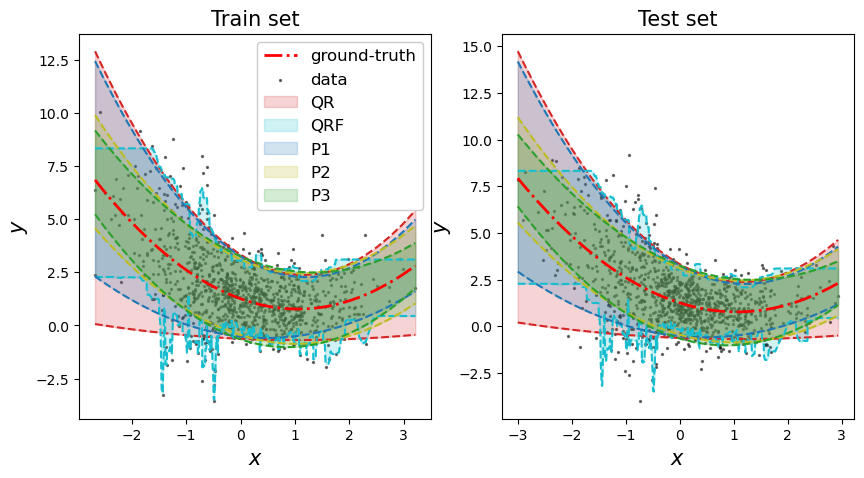

In [41]:
fig,ax = plt.subplots(nrows=1,ncols=2)
fig.set_size_inches(10,5)
colorlist = ['tab:red','tab:cyan','tab:blue','tab:olive','tab:green']
labellist = ['QR','QRF','P1','P2','P3']
# colorlist = ['tab:red','tab:blue','tab:olive','tab:green']
# labellist = ['QR','P1','P2','P3']
dataplot = data_quad
# High variance
ax[0].plot(dataplot['x'],dataplot['y0'],color='red',linestyle='-.',linewidth=2,label='ground-truth')
ax[0].scatter(dataplot['x'],dataplot['y'],color='black',alpha=0.5,s=2,label='data')
for i in range(len(colorlist)):
    ax[0].plot(dataplot['x'],dataplot['yhat'][:,0,i],color=colorlist[i],linestyle='dashed')
    ax[0].plot(dataplot['x'],dataplot['yhat'][:,1,i],color=colorlist[i],linestyle='dashed')
    ax[0].fill_between(dataplot['x'].flatten(),dataplot['yhat'][:,0,i],dataplot['yhat'][:,1,i],alpha=0.2,color=colorlist[i],label=labellist[i])

ax[0].set_title('Train set',fontsize=15)
ax[0].set_xlabel('$x$',fontsize=15)
ax[0].set_ylabel('$y$',fontsize=15)
ax[0].legend(fontsize=12,framealpha=1)

ax[1].plot(dataplot['xtest'],dataplot['y0test'],color='red',linestyle='-.',linewidth=2,label='ground-truth')
ax[1].scatter(dataplot['xtest'],dataplot['ytest'],color='black',alpha=0.5,s=2,label='data')
for i in range(len(colorlist)):
    ax[1].plot(dataplot['xtest'],dataplot['yhattest'][:,0,i],color=colorlist[i],linestyle='dashed')
    ax[1].plot(dataplot['xtest'],dataplot['yhattest'][:,1,i],color=colorlist[i],linestyle='dashed')
    ax[1].fill_between(dataplot['xtest'].flatten(),dataplot['yhattest'][:,0,i],dataplot['yhattest'][:,1,i],alpha=0.2,color=colorlist[i],label=labellist[i])

ax[1].set_title('Test set',fontsize=15)
ax[1].set_xlabel('$x$',fontsize=15)
ax[1].set_ylabel('$y$',fontsize=15)
# report_savefig('quadfit-highnoise')


### Low variance data

In [ ]:
conf_int = 0.9
quantiles_vary = [round((1-conf_int)/2,4),round((1+conf_int)/2,4)]
k = 0
for quantile in quantiles_vary: #Iterate LB and UB
    if quantile == quantiles_vary[0]: #For lower bound
        common_params = dict(max_depth=10,
                                max_features = None,
                                min_samples_leaf=4,
                                min_samples_split=20,
                                n_estimators=100)
    else: #For upper bound
        common_params = dict(max_depth=20,
                                max_features = None,
                                min_samples_leaf=30,
                                min_samples_split=30,
                                n_estimators=250)
    qrf = RandomForestQuantileRegressor(**common_params, q=quantile)
    qrf.fit(data_quad_lownoise['x'], data_quad_lownoise['y'].ravel())    
    data_quad_lownoise['yhat'][:,k,1] = qrf.predict(data_quad_lownoise['x'])
    data_quad_lownoise['yhattest'][:,k,1] = qrf.predict(data_quad_lownoise['xtest'])
    k = k + 1

In [ ]:
# Save
dict_path = os.path.join(resultfolderpath, 'data_quad_lownoise.pkl')
with open(dict_path,'wb') as pickle_file:
    pickle.dump(data_quad_lownoise,pickle_file)

#### Import low variance result

In [42]:
# Load
dict_path = os.path.join(resultfolderpath, 'data_quad_lownoise.pkl')
with open(dict_path, 'rb') as pickle_file:
    data_quad_lownoise = pickle.load(pickle_file)

Text(0, 0.5, '$y$')

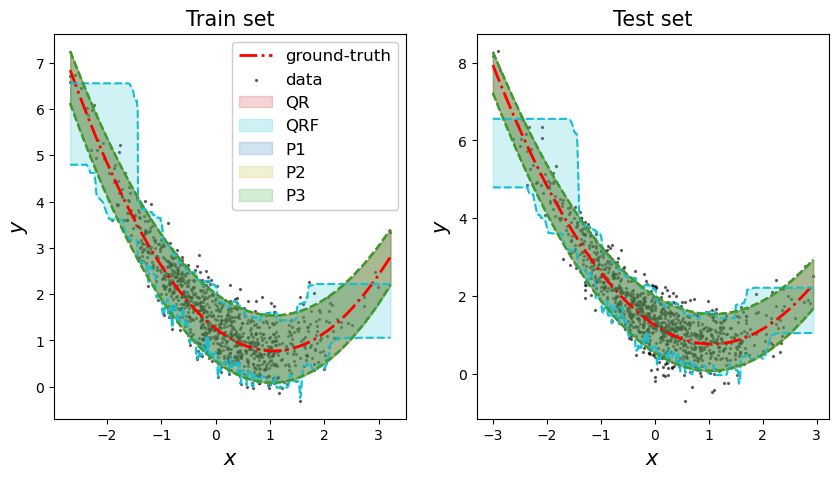

In [43]:
fig,ax = plt.subplots(nrows=1,ncols=2)
fig.set_size_inches(10,5)
colorlist = ['tab:red','tab:cyan','tab:blue','tab:olive','tab:green']
labellist = ['QR','QRF','P1','P2','P3']
# colorlist = ['tab:red','tab:blue','tab:olive','tab:green']
# labellist = ['QR','P1','P2','P3']
dataplot = data_quad_lownoise
# High variance
ax[0].plot(dataplot['x'],dataplot['y0'],color='red',linestyle='-.',linewidth=2,label='ground-truth')
ax[0].scatter(dataplot['x'],dataplot['y'],color='black',alpha=0.5,s=2,label='data')
for i in range(len(colorlist)):
    ax[0].plot(dataplot['x'],dataplot['yhat'][:,0,i],color=colorlist[i],linestyle='dashed')
    ax[0].plot(dataplot['x'],dataplot['yhat'][:,1,i],color=colorlist[i],linestyle='dashed')
    ax[0].fill_between(dataplot['x'].flatten(),dataplot['yhat'][:,0,i],dataplot['yhat'][:,1,i],alpha=0.2,color=colorlist[i],label=labellist[i])

ax[0].set_title('Train set',fontsize=15)
ax[0].set_xlabel('$x$',fontsize=15)
ax[0].set_ylabel('$y$',fontsize=15)
ax[0].legend(fontsize=12,framealpha=1)

ax[1].plot(dataplot['xtest'],dataplot['y0test'],color='red',linestyle='-.',linewidth=2,label='ground-truth')
ax[1].scatter(dataplot['xtest'],dataplot['ytest'],color='black',alpha=0.5,s=2,label='data')
for i in range(len(colorlist)):
    ax[1].plot(dataplot['xtest'],dataplot['yhattest'][:,0,i],color=colorlist[i],linestyle='dashed')
    ax[1].plot(dataplot['xtest'],dataplot['yhattest'][:,1,i],color=colorlist[i],linestyle='dashed')
    ax[1].fill_between(dataplot['xtest'].flatten(),dataplot['yhattest'][:,0,i],dataplot['yhattest'][:,1,i],alpha=0.2,color=colorlist[i],label=labellist[i])

ax[1].set_title('Test set',fontsize=15)
ax[1].set_xlabel('$x$',fontsize=15)
ax[1].set_ylabel('$y$',fontsize=15)
# report_savefig('quadfit-lownoise')